# After training analysis
Create table and plots; reuse code from `mlp-classifier-experiments
`

In [1]:
import pickle

import string
import editdistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [25]:
sns.set_theme()
sns.set_context('paper')
plt.style.use('ggplot')

In [2]:
punctuations = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

In [3]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

In [ ]:
def clean_text(text, remove_punkt=False, remove_stopwords=False, stem=False):
    tokens = word_tokenize(text.lower())
    if remove_punkt:
        tokens = [tok for tok in tokens if not tok in punctuations]
    if remove_stopwords:
        tokens = [tok for tok in tokens if not tok in stopwords]
    if stem:
        tokens = [ps.stem(tok) for tok in tokens]
    return tokens

In [ ]:
def construct_features(first_lines, second_lines):
    # number of unique overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

In [4]:
dev = load_file('data/dev+devtest/dev.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
test = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
test_hard = load_file('data/heldout-hard/test.hard.tsv', has_label=False)

In [5]:
with open('output/mlp-experiments.pkl', 'rb') as f:
    experiments = pickle.load(f)

In [6]:
results = pd.read_csv('output/mlp-results.csv')

# Accuracy tables and plots

In [10]:
results

,config,dataset,train_accu,val_accu
0,baseline,normal,0.841076,0.813665
1,baseline_hard,hard,0.725000,0.700000
2,tokenized,normal,0.844743,0.829814
3,tokenized_hard,hard,0.689000,0.668000
4,big,normal,0.842235,0.837438
5,big_hard,hard,0.681333,0.686000
6,combined,normal,0.690099,0.667770
7,combined_normal,normal,0.690099,0.812808
8,combined_hard,hard,0.690099,0.550000
9,no_punkt,normal,0.823336,0.852217


In [17]:
df = results.melt(id_vars=['config', 'dataset'], value_vars=['train_accu', 'val_accu'])

In [18]:
df.head()

,config,dataset,variable,value
0,baseline,normal,train_accu,0.841076
1,baseline_hard,hard,train_accu,0.725000
2,tokenized,normal,train_accu,0.844743
3,tokenized_hard,hard,train_accu,0.689000
4,big,normal,train_accu,0.842235


<AxesSubplot:xlabel='variable', ylabel='value'>

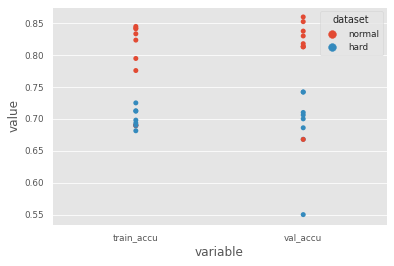

In [28]:
sns.stripplot(data=df, x='variable', y='value', hue='dataset', jitter=False)

# Text cleaning on example sentences

# Feature visualization

Violin plots: `tokenized, tokenized-rmv-punkt`, `hue=difficulty`

# Error analysis